# TRABAJO PRACTICO: Modelo de predicción de Attrition Bancario

## Objetivo
El objetivo de este trabajo es construir un modelo que permita predecir qué clientes se van a ir del banco el mes próximo.

Recursos Adicionales

- [scikit-learn documentación de árboles de decisión](http://scikit-learn.org/stable/modules/tree.html)
- [Gini Vs Entropia](http://www.garysieling.com/blog/sklearn-gini-vs-entropy-criteria)

## 1. Análisis descriptivo del dataset

El set de entrenamiento a utilizar es **dataset_training.csv** el cual contiene información sobre 60903 clientes (personas físicas) con paquetes "Premium" de una entidad bancaria. En el archivo **DiccionarioDatos-TP.xls** se especifica la descripción de cada uno de sus 36 atributos y algunas aclaraciones sobre la información suministrada.

Instrucciones:

1. Instalar todas las librerias python que aquí se incluyen.
2. Instalar graph visualizer en windows: https://graphviz.gitlab.io/_pages/Download/Download_windows.html
3. Leer los datos con Pandas.
   - Explorar los datos ordenándolos o graficándolos.

In [1]:
# Librerias a importar
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
import copy
import matplotlib.pyplot as plt

# Por defecto, matplotlib crea una figura en una ventana separada. Cuando usamos Jupyter notebooks, podemos hacer que las 
# figuras aparezcan en línea dentro del notebook. Esto lo hacemos ejecutando: 
%matplotlib inline 

from IPython.display import Image

# Scikit-learn (sklearn) es una librería que implementa algunos algoritmos de Machine Learning y pre-procesamiento de datos.

from sklearn.tree import export_graphviz  
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics.scorer import make_scorer
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder


In [2]:
# Leemos el dataset de entrenamiento
dataset_entrenamiento='dataset_training.csv'
df = pd.read_csv(dataset_entrenamiento, sep =';', na_values = '.', index_col = 0)
df.head(10)

,FOTO_MES,CLIENTE_EDAD,CLIENTE_ANTIGUEDAD,MRENTABILIDAD,MACTIVOS_MARGEN,MPASIVOS_MARGEN,MCUENTAS_SALDO,MAUTOSERVICIO,TTARJETA_VISA,CTARJETA_VISA_TRANSACCIONES,...,MASTER_TADELANTOSEFECTIVO,VISA_MARCA_ATRASO,VISA_CUENTA_ESTADO,VISA_MSALDOTOTAL,VISA_MLIMITECOMPRA,VISA_MADELANTOPESOS,VISA_MCONSUMOTOTAL,VISA_TCONSUMOS,VISA_TADELANTOSEFECTIVO,CLASE
NUMERO_DE_CLIENTE,,,,,,,,,,,,,,,,,,,,,
38104841,01/03/18,64,57,689.93,7.56,62.63,-684.20,0.00,1,10,...,NaN,0.0,NORMAL,9711.58,49140.00,0.0,3005.65,4.0,0.0,CONTINUA
38106842,01/03/18,42,56,11.65,17.81,9.88,80.78,0.00,1,10,...,NaN,0.0,NORMAL,7735.28,42120.00,0.0,156.94,3.0,0.0,CONTINUA
38107769,01/03/18,27,56,532.97,-159.25,336.16,4003.75,257.40,1,44,...,NaN,0.0,NORMAL,18110.17,28080.00,0.0,13173.33,26.0,0.0,CONTINUA
38109170,01/03/18,30,57,1470.24,806.78,172.11,15586.23,151.51,1,23,...,0.0,0.0,NORMAL,13694.17,56160.00,0.0,8526.55,15.0,0.0,CONTINUA
38109996,01/03/18,43,57,2225.23,-22.45,1180.57,118891.09,4825.08,1,5,...,0.0,0.0,NORMAL,6686.81,28080.00,0.0,7823.56,6.0,0.0,CONTINUA
38110128,01/03/18,31,57,522.07,-136.85,181.09,1316.27,23370.60,1,19,...,0.0,0.0,NORMAL,10905.17,42120.00,0.0,6642.23,8.0,0.0,CONTINUA
38111061,01/03/18,49,56,473.14,-400.36,466.06,279.96,3399.23,1,30,...,NaN,0.0,NORMAL,19840.80,42120.00,0.0,20655.98,22.0,0.0,CONTINUA
38111752,01/03/18,42,57,1129.27,-50.18,895.27,439026.00,7085.94,1,4,...,NaN,0.0,NORMAL,687.46,124232.06,0.0,0.00,0.0,0.0,CONTINUA
38114445,01/03/18,55,4,358.60,-297.49,386.91,-131.09,0.00,1,26,...,0.0,0.0,NORMAL,13864.93,24570.00,0.0,12241.56,18.0,0.0,BAJA


In [7]:
# ¿Qué información estadística obtenemos del dataset?
df.describe()

,CLIENTE_EDAD,CLIENTE_ANTIGUEDAD,MRENTABILIDAD,MACTIVOS_MARGEN,MPASIVOS_MARGEN,MCUENTAS_SALDO,MAUTOSERVICIO,TTARJETA_VISA,CTARJETA_VISA_TRANSACCIONES,CPRESTAMOS_PERSONALES,...,MASTER_TCONSUMOS,MASTER_TADELANTOSEFECTIVO,VISA_MARCA_ATRASO,VISA_MSALDOTOTAL,VISA_MLIMITECOMPRA,VISA_MADELANTOPESOS,VISA_MCONSUMOTOTAL,VISA_TCONSUMOS,VISA_TADELANTOSEFECTIVO,CLASE_NUM
count,60903.000000,60903.000000,60903.000000,60903.000000,60903.000000,6.090300e+04,60903.000000,60903.000000,60903.000000,60903.000000,...,27858.000000,27858.000000,58987.000000,5.898700e+04,5.898700e+04,53240.000000,53240.000000,53240.000000,53240.000000,60903.000000
mean,46.435775,123.262220,2057.872272,193.119365,881.267262,1.175270e+05,4492.501802,0.979032,12.323104,0.773279,...,2.879819,0.032558,0.016004,1.563778e+04,1.052937e+05,57.997984,9356.719506,8.506367,0.026559,0.044448
std,12.660386,80.556752,3666.399138,1032.130756,2079.405010,4.943238e+05,7815.966973,0.243406,13.968946,1.997755,...,4.872697,0.427266,0.125490,2.760331e+04,1.030251e+05,780.227485,16514.558483,10.108106,0.343573,0.206089
min,18.000000,1.000000,-27452.770000,-53630.140000,-4500.310000,-8.750316e+05,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.770707e+05,1.009120e+03,0.000000,-35512.010000,0.000000,0.000000,0.000000
25%,37.000000,57.000000,736.210000,-155.900000,130.180000,6.802500e+01,0.000000,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,2.148595e+03,3.510000e+04,0.000000,987.882500,2.000000,0.000000,0.000000
50%,45.000000,115.000000,1335.430000,0.000000,371.150000,1.487404e+04,1021.420000,1.000000,8.000000,0.000000,...,1.000000,0.000000,0.000000,7.557720e+03,5.616000e+04,0.000000,4224.925000,5.000000,0.000000,0.000000
75%,55.000000,171.000000,2375.480000,326.115000,896.815000,7.534579e+04,6037.365000,1.000000,17.000000,1.000000,...,3.000000,0.000000,0.000000,1.813876e+04,1.250613e+05,0.000000,11146.852500,11.000000,0.000000,0.000000
max,99.000000,339.000000,435890.200000,44427.990000,184290.870000,2.570106e+07,148436.080000,3.000000,194.000000,67.000000,...,116.000000,13.000000,1.000000,1.261831e+06,3.228826e+06,29665.560000,812473.010000,196.000000,17.000000,1.000000


CONTINUA    95.555227
BAJA         4.444773
Name: CLASE, dtype: float64
CONTINUA    58196
BAJA         2707
Name: CLASE, dtype: int64


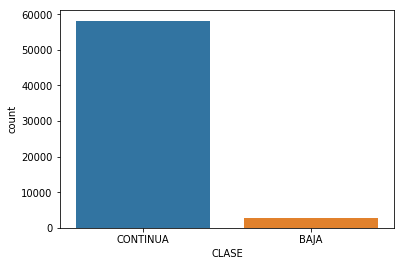

In [8]:
# Veamos la distribución de clientes que se dieron de baja de los que continuan
print(df['CLASE'].value_counts(normalize = True)*100) # expresado en porcentajes
print(df['CLASE'].value_counts(normalize = False)) # expresado en nominal
sns.countplot(x='CLASE', data=df)


### 1.a) Análisis de correlación de variables
 
Una matriz de correlación permite estudiar la relación lineal o comportamiento que puede existir entre dos o más variables.

  - Correlación positiva: ocurre cuando una variable aumenta y la otra también.
  - Correlación negativa: es cuando una variable aumenta y la otra disminuye. 
  - Sin correlación: no hay una relación aparente entre las variables. 

In [4]:
# Creamos una variable numerica CLASE_NUM a partir de nuestra variable objetivo CLASE. 
# La misma tendrá un valor 1 cuando el cliente sea una BAJA y un 0 cuando CONTINUA como cliente. 
# Esta variable se usará para calcular la correlacion lineal entre las variables númericas y la variable objetivo.

df['CLASE_NUM'] = list(map(lambda clase: 1 if (clase == 'BAJA') else 0, df['CLASE']))

# Calculamos la matriz de correlacion entre todas las variables del dataset. 
df.corr()


,CLIENTE_EDAD,CLIENTE_ANTIGUEDAD,MRENTABILIDAD,MACTIVOS_MARGEN,MPASIVOS_MARGEN,MCUENTAS_SALDO,MAUTOSERVICIO,TTARJETA_VISA,CTARJETA_VISA_TRANSACCIONES,CPRESTAMOS_PERSONALES,...,MASTER_TCONSUMOS,MASTER_TADELANTOSEFECTIVO,VISA_MARCA_ATRASO,VISA_MSALDOTOTAL,VISA_MLIMITECOMPRA,VISA_MADELANTOPESOS,VISA_MCONSUMOTOTAL,VISA_TCONSUMOS,VISA_TADELANTOSEFECTIVO,CLASE_NUM
CLIENTE_EDAD,1.000000,0.388649,0.086099,-0.074255,0.097706,0.073263,-0.076144,0.050877,0.050207,-0.041880,...,0.073257,0.004550,-0.041187,0.053546,0.211719,-0.007384,0.091762,0.075134,-0.009804,0.005137
CLIENTE_ANTIGUEDAD,0.388649,1.000000,0.098886,-0.104617,0.133900,0.096691,0.092687,0.108943,0.209470,0.002476,...,0.103794,-0.006112,-0.063145,0.113241,0.232686,-0.007969,0.146399,0.191272,-0.011496,-0.088344
MRENTABILIDAD,0.086099,0.098886,1.000000,0.264548,0.711415,0.439617,0.142526,0.044909,0.125991,0.042847,...,0.085162,0.014890,0.031793,0.200270,0.283081,0.016096,0.206842,0.132417,0.014766,-0.021081
MACTIVOS_MARGEN,-0.074255,-0.104617,0.264548,1.000000,-0.120347,-0.077233,-0.016255,-0.088384,-0.079155,0.299616,...,-0.053538,0.072886,0.106787,0.066811,-0.104633,0.056067,-0.171353,-0.122582,0.060140,0.053395
MPASIVOS_MARGEN,0.097706,0.133900,0.711415,-0.120347,1.000000,0.604360,0.191207,0.090074,0.108065,-0.079001,...,0.087123,-0.011320,-0.044751,0.119482,0.296584,-0.005311,0.228425,0.136831,-0.007177,-0.071608
MCUENTAS_SALDO,0.073263,0.096691,0.439617,-0.077233,0.604360,1.000000,0.087110,0.055804,0.062454,-0.067500,...,0.048981,-0.015480,-0.031309,0.040530,0.180970,-0.009849,0.128604,0.093859,-0.011266,-0.053440
MAUTOSERVICIO,-0.076144,0.092687,0.142526,-0.016255,0.191207,0.087110,1.000000,0.067661,0.047285,-0.006035,...,-0.031993,-0.015756,-0.055985,0.026063,0.114945,-0.017252,0.036651,0.005765,-0.017435,-0.100731
TTARJETA_VISA,0.050877,0.108943,0.044909,-0.088384,0.090074,0.055804,0.067661,1.000000,0.175887,-0.028281,...,0.024407,-0.007940,-0.134086,0.026811,0.109651,-0.002450,0.074286,0.072191,-0.002269,-0.276997
CTARJETA_VISA_TRANSACCIONES,0.050207,0.209470,0.125991,-0.079155,0.108065,0.062454,0.047285,0.175887,1.000000,0.098496,...,0.235887,0.036803,-0.038233,0.483582,0.279007,0.058379,0.544474,0.849699,0.056369,-0.140883
CPRESTAMOS_PERSONALES,-0.041880,0.002476,0.042847,0.299616,-0.079001,-0.067500,-0.006035,-0.028281,0.098496,1.000000,...,0.009514,0.108551,0.091451,0.127666,-0.066065,0.099552,-0.033523,0.004791,0.110258,-0.005155


In [9]:
# Seleccionamos sólo la correlacion de la variable objetivo numerica CLASE_NUM.
#dfd = df.corr()[["CLASE_NUM"]]*100
#dfd
df_v = copy.copy(df)
df_v = preparacion_de_datos(df_v)
df_v_corr = df_v.corr()[["CLASE_NUM"]]*100
df_v_corr

,CLASE_NUM
CLIENTE_EDAD,0.513743
CLIENTE_ANTIGUEDAD,-8.834424
MRENTABILIDAD,-2.108100
MACTIVOS_MARGEN,5.339453
MPASIVOS_MARGEN,-7.160841
MCUENTAS_SALDO,-5.344032
MAUTOSERVICIO,-10.073094
TTARJETA_VISA,-27.699732
CTARJETA_VISA_TRANSACCIONES,-14.088264
CPRESTAMOS_PERSONALES,-0.515530


In [10]:
# Borramos la correlacion de la variable objetivo numerica consigo misma.
#dfd = dfd.drop("CLASE_NUM", axis=0)   # CLASE_NUM = 100

# Ordenamos las variables de forma decreciente por el valor de correlacion positiva con la variable objetivo.
#dfd = dfd.sort_values(["CLASE_NUM"], ascending=False)
#dfd

df_v_corr=df_v_corr.drop("CLASE_NUM", axis=0)
df_v_corr=df_v_corr.drop("CLASE", axis=0)
df_v_corr = df_v_corr.sort_values(["CLASE_NUM"], ascending=False)
df_v_corr

,CLASE_NUM
G_CUENTA_ESTADO,31.665415
VISA_MARCA_ATRASO,23.414824
G_VISA_MASTER_MARCA_ATRASO,23.098236
G_CUENTA_ESTADO2,20.905653
MASTER_MARCA_ATRASO,18.736716
C_MASTER_SALDO_LIM,5.913867
MACTIVOS_MARGEN,5.339453
C_VISA_MATER_SALDO_LIM,3.717811
C_VISA_SALDO_LIM,3.075686
MASTER_MSALDOTOTAL,1.760801


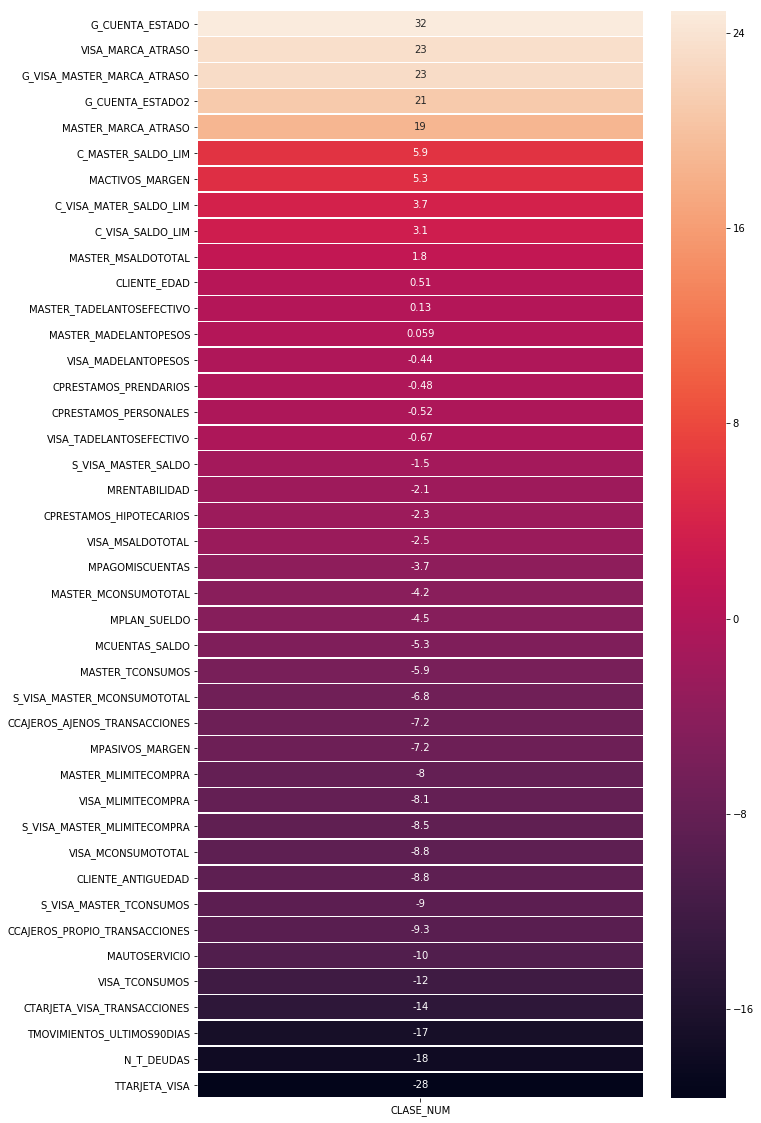

In [11]:
# Graficamos el mapa de calor.
#plt.figure(figsize=(10, 20))
#sns.heatmap(dfd, robust=True, linewidths=.5, annot=True, )

# Para terminar borramos la variable numérica creada
df.drop('CLASE_NUM', axis=1, inplace=True)

plt.figure(figsize=(10, 20))
sns.heatmap(df_v_corr, robust=True, linewidths=.5, annot=True, )

### Análisis preliminar

Del mapa de calor se puede observar que existe una alta correlación positiva entre las variables VISA_MARCA_ATRASO y MASTER_MARCA_ATRASO respecto a la posibilidad que un cliente se de baja. Al parecer, esto indicaría que aquellos clientes que no realizan el pago mínimo de las tarjetas o están atrasados en los pagos son más propensos a darse de baja. Las restantes variables con correlación positiva tendrán relación con la observación preliminar realizada? 

### 1.b) Análisis de la edad y antigüedad de un cliente

Vamos a analizar ahora cómo afecta la edad y antigüedad del cliente con la posibilidad a darse de baja.

[]

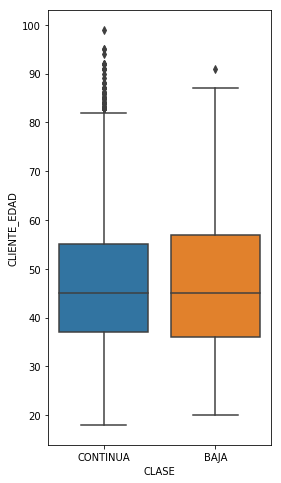

In [12]:
# Creamos un gráfico boxplot para analizar la EDAD del cliente respecto a la CLASE
plt.figure(figsize=(4, 8))
s=sns.boxplot(x="CLASE", y="CLIENTE_EDAD", data=df)
s.plot()

- ¿Se observa alguna relación respecto a la edad del cliente entre aquellos que se dan de baja de los que no?

[]

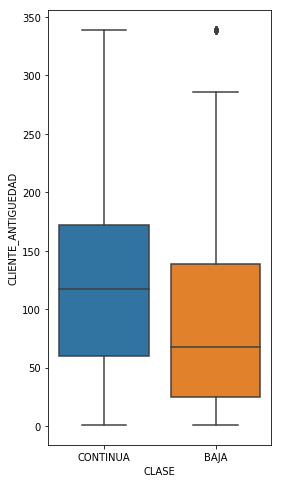

In [13]:
# Creamos un gráfico boxplot para analizar la ANTIGÜEDAD del cliente respecto a la CLASE
plt.figure(figsize=(4, 8))
s2=sns.boxplot(x="CLASE", y="CLIENTE_ANTIGUEDAD", data=df)
s2.plot()

- ¿Se observa alguna relación respecto a la antigüedad del cliente entre aquellos que se dan de baja de los que no?

### 1.c) Análisis del estado de las tarjetas (VISA y MASTERCARD)

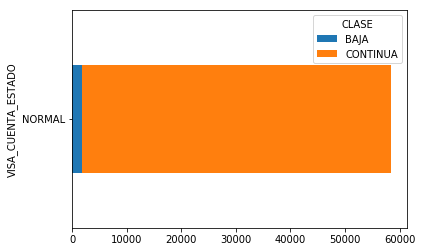

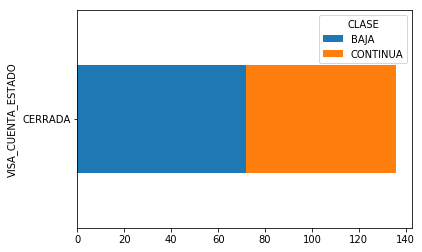

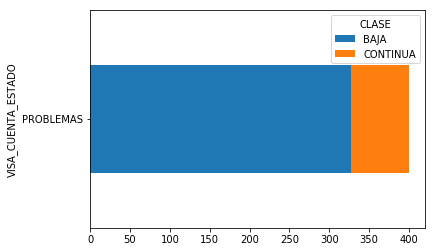

In [14]:
# Estado de la tarjeta VISA
ct = pd.crosstab(df.VISA_CUENTA_ESTADO, df.CLASE, margins=False)   # arma una tabla cruzada
ct.loc[["NORMAL"]].plot.barh(stacked=True)  # loc trabaja en las etiquetas del índice para armar un gráfico de barras
ct.loc[["CERRADA"]].plot.barh(stacked=True)
ct.loc[["PROBLEMAS"]].plot.barh(stacked=True)

plt.show()

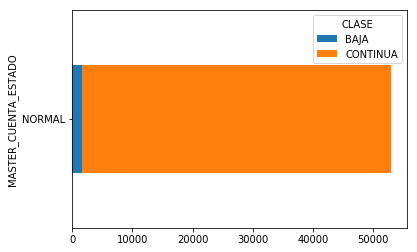

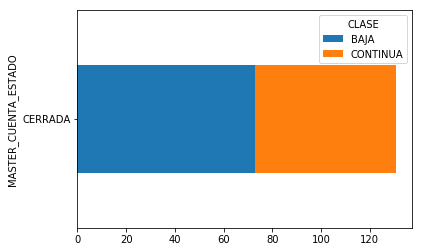

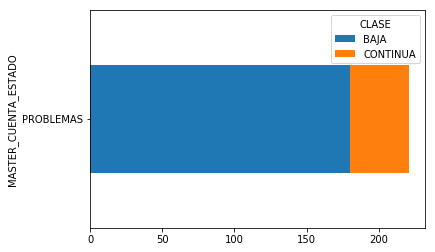

In [15]:
# Estado de la tarjeta MASTERCARD
ct2 = pd.crosstab(df.MASTER_CUENTA_ESTADO, df.CLASE, margins=False)
ct2.loc[["NORMAL"]].plot.barh(stacked=True)
ct2.loc[["CERRADA"]].plot.barh(stacked=True)
ct2.loc[["PROBLEMAS"]].plot.barh(stacked=True)

plt.show()

### Análisis preliminar

Según se puede observar en ambas tarjetas, los clientes que tienen la cuenta "CERRADA" o con "PROBLEMAS" tienen muchísima mayor probabilidad de irse del banco.

### 1.d) Análisis del atraso en el pago de las tarjetas (VISA y MASTERCARD)
Los atributos que marcan el atraso en el pago de las tarjetas son VISA_MARCA_ATRASO y MASTER_MARCA_ATRASO.

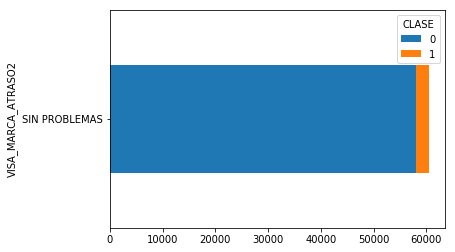

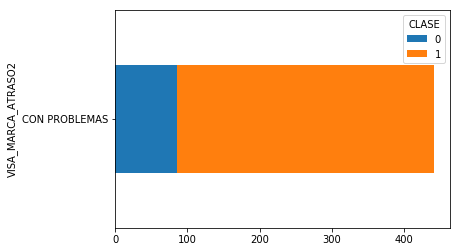

In [16]:
#___________Nuestro__________#
df_v['VISA_MARCA_ATRASO2'] = list(map(lambda marca: 'CON PROBLEMAS'
                                      if (marca > 0 ) else 'SIN PROBLEMAS', df_v['G_CUENTA_ESTADO']))
ct3 = pd.crosstab(df_v.VISA_MARCA_ATRASO2, df_v.CLASE, margins=False)

ct3.loc[["SIN PROBLEMAS"]].plot.barh(stacked=True)
ct3.loc[["CON PROBLEMAS"]].plot.barh(stacked=True)
df_v.drop('VISA_MARCA_ATRASO2', axis=1, inplace=True)

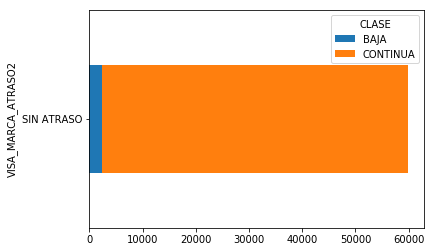

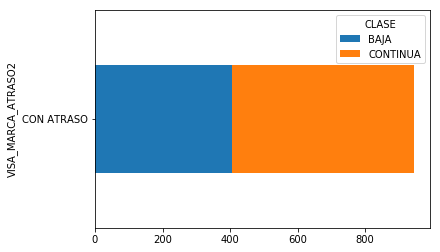

In [17]:
# Como ambos atributos son numericos creamos dos variables auxiliares "categoricas" para ver cómo se comportan
df['VISA_MARCA_ATRASO2'] = list(map(lambda marca: 'CON ATRASO' if (marca > 0 ) else 'SIN ATRASO', df['VISA_MARCA_ATRASO']))


ct3 = pd.crosstab(df.VISA_MARCA_ATRASO2, df.CLASE, margins=False)

ct3.loc[["SIN ATRASO"]].plot.barh(stacked=True)
ct3.loc[["CON ATRASO"]].plot.barh(stacked=True)

# Para terminar borramos la variable auxiliar creada
df.drop('VISA_MARCA_ATRASO2', axis=1, inplace=True)

plt.show()


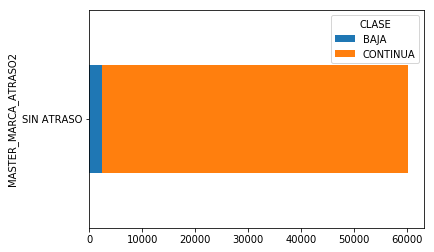

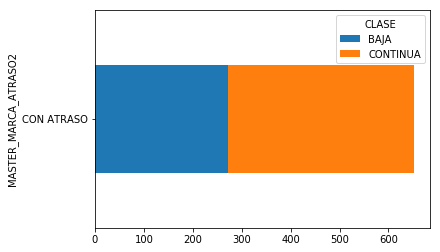

In [18]:
df['MASTER_MARCA_ATRASO2'] = list(map(lambda marca: 'CON ATRASO' if (marca > 0 ) else 'SIN ATRASO', df['MASTER_MARCA_ATRASO']))
ct4 = pd.crosstab(df.MASTER_MARCA_ATRASO2, df.CLASE, margins=False)
ct4.loc[["SIN ATRASO"]].plot.barh(stacked=True)
ct4.loc[["CON ATRASO"]].plot.barh(stacked=True)
plt.show()

# Para terminar borramos la variable auxiliar creada
df.drop('MASTER_MARCA_ATRASO2', axis=1, inplace=True)

- ¿Qué puede decirse del análisis realizado?

## 2. Preparación de datos

Una vez cargados los datos y analizados, se deben preparar para ser procesados. Los 3 pasos generales que se deben seguir son:

1. Tratamiento de outliers (no se aplica en modelos con árboles de decisión)
2. Feature engineering 
3. Tratamiento de missing values (o valores nulos)

Para el paso de feature engineering se podría usar la libreria "featuretools" la documentación se puede encontrar en:
https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html

Con esta librería se generarán automáticamente las combinaciones "primitivas" posibles entre las variables que tenemos. Como ejemplo, la división de una variable con otra, el máximo, minimo, mediana, etc.

Vamos a crear una función llamada **preparacion_de_datos(dataset)** que incluirá todas las tareas de preparación de datos necesarias para construir nuestro modelo predictivo. Esta función la vamos a utilizar tanto para el dataset de entrenamiento como para el de prueba.

****A partir de este momento, la variable CLASE (objetivo) deja de ser una etiqueta para convertirse en una variable numerica, con valores: 0 (CONTINUAN) 1 (BAJA)****

In [6]:
# FUNCION preparacion_de_datos (parametro_entrada)

def preparacion_de_datos(df_e):
  #Comenzamos haciendo una copia del dataset que la función recibe como parámetro de entrada
  df_s = copy.copy(df_e)

  # Convertimos la variable clase en un numerico con 0 o 1
  df_s['CLASE'] = list(map(lambda clase: 1 if (clase == 'BAJA') else 0, df_s['CLASE']))
  
  # FEATURE ENGINEERING 
  # Vamos a crear 3 atributos nuevos a partir de los datos que ya tenemos, generando otras características de los clientes.
  # Cada uno puede crear los atributos que considere necesario (y mejoren la predicción)
    
  # Los atributos que vamos a crear son:

  ## 1) Cociente entre el saldo de la tarjeta y el limite, para saber qué % del límite que tiene está usando. 
  ## Las variables "Cocientes" las vamos a indicar con "C_")

  df_s['C_VISA_SALDO_LIM'] = list(map(lambda saldo, limite:
                                      saldo/limite if (limite > 0) else 0,
                                      df_s['VISA_MSALDOTOTAL'],
                                      df_s['VISA_MLIMITECOMPRA']))
    
  ## 2) Suma del saldo en ambas tarjetas (MASTER Y VISA). Las variables "Sumas" las vamos a indicar con "S_"
  
  df_s['S_VISA_MASTER_SALDO'] = ( df['VISA_MSALDOTOTAL'] + df['MASTER_MSALDOTOTAL'] )


  ## 3) Variable conceptual del negocio para indicar si el cliente tiene alguna deuda con el banco. 
  ## La constuirmos a partir de la cantidad de préstamos personales, prendarios e hipotecarios que tenga el cliente.
  ## Las variables del "Negocio" las vamos a indicar con "N_"

  df_s['N_T_DEUDAS'] = list(map(lambda pp, pr, ph, tc:
                                1 if (pp > 0 or pr >0 or ph >0 or tc >0 ) 
                                else 0, 
                                df_s['CPRESTAMOS_PERSONALES'], 
                                df_s['CPRESTAMOS_PRENDARIOS'],
                                df_s['CPRESTAMOS_HIPOTECARIOS'],
                                df_s['S_VISA_MASTER_SALDO']))


  # ------------- NUESTRAS VARIABLES -----------------
  # Si tiene atraso en alguna tarjeta
  df_s['G_VISA_MASTER_MARCA_ATRASO'] = list(map(lambda marca_visa, marca_master:
                                              1 if (marca_visa > 0 or marca_master > 0) else 0,
                                              df_s['VISA_MARCA_ATRASO'],
                                              df_s['MASTER_MARCA_ATRASO']))

  # Suma de limites de tarjetas
  df_s['S_VISA_MASTER_MLIMITECOMPRA'] = ( df['VISA_MLIMITECOMPRA'] + df['MASTER_MLIMITECOMPRA'] )

  # Cociente entre suma de saldos y suma de limites de las tarjetas
  df_s['C_VISA_MATER_SALDO_LIM'] = list(map(lambda saldo, limite:
                                          saldo/limite if (limite > 0) else 0,
                                          df_s['S_VISA_MASTER_SALDO'],
                                          df_s['S_VISA_MASTER_MLIMITECOMPRA']))
    
  # Cociente entre saldo y limite de mastercard
  df_s['C_MASTER_SALDO_LIM'] = list(map(lambda saldo, limite:
                                      saldo/limite if (limite > 0) else 0,
                                      df_s['MASTER_MSALDOTOTAL'],
                                      df_s['MASTER_MLIMITECOMPRA']))
  # Suma de TCONSUMOS
  df_s['S_VISA_MASTER_TCONSUMOS'] = ( df['VISA_TCONSUMOS'] + df['MASTER_TCONSUMOS'] )

  # Suma de MCONSUMOTOTAL
  df_s['S_VISA_MASTER_MCONSUMOTOTAL'] = ( df['VISA_MCONSUMOTOTAL'] + df['MASTER_MCONSUMOTOTAL'] )
    
  #problemas en cuentas
  df_s['G_CUENTA_ESTADO'] = list(map(lambda master, visa:
                                     1 if (master == 'PROBLEMAS' or visa == 'PROBLEMAS')
                                     else 0,
                                     df_s['MASTER_CUENTA_ESTADO'], 
                                     df_s['VISA_CUENTA_ESTADO']))
  #problemas en ambas cuentas
  df_s['G_CUENTA_ESTADO2'] = list(map(lambda master, visa:
                                     1 if (master == 'PROBLEMAS' and visa == 'PROBLEMAS')
                                     else 0,
                                     df_s['MASTER_CUENTA_ESTADO'], 
                                     df_s['VISA_CUENTA_ESTADO']))
  
  # TRATAMIENTO DE VALORES NULOS
  # Veamos si tenemos valores nulos o infinitos. Para simplificar el análisis, reemplazaremos ambos casos por el valor 0
  df_s[df_s==np.inf]=np.nan
  df_s.fillna(0, inplace=True)
    
  return df_s

## 3. Construcción del modelo predictivo sin optimizacion de hiperparámetros
### 3.a) Modelo inicial 

Vamos a construir un árbol de clasificación inicial usando el dataset. Los pasos que realizaremos son:

- Leer los datos con Pandas.
- Comprobar si hay valores nulos y crear todas las variables nuevas.
- Encodear todos los atributos categóricos como booleanos usando `pd.get_dummies`
- Encodear las etiquetas usando `LabelEncoder`
- Construir una variable Y que contenga la variable objetivo a predecir y una vector X que contenga todo el resto de variables a usar en la predicción.
- Dividir el dataset completo en training y testing
- Dividir X e y con train_test_split así:
        train_test_split(X, y, test_size=0.3, random_state=42)
- Ajustar un árbol de clasificación con `max_depth=3`
- Visualizar el árbol usando graphviz
- Calcular la importancia de los atributos
- Calcular y mostrar la matriz de confusión
- Sacar la restricción de `max_depth=3` y ver si la clasificación mejora

In [19]:
# Ejecutamos la función de preparacion de datos. 
# Este el primer paso que debemos realizar para tener todas las variables a utilizar.

df = preparacion_de_datos(df)
df.head()


,FOTO_MES,CLIENTE_EDAD,CLIENTE_ANTIGUEDAD,MRENTABILIDAD,MACTIVOS_MARGEN,MPASIVOS_MARGEN,MCUENTAS_SALDO,MAUTOSERVICIO,TTARJETA_VISA,CTARJETA_VISA_TRANSACCIONES,...,S_VISA_MASTER_SALDO,N_T_DEUDAS,G_VISA_MASTER_MARCA_ATRASO,S_VISA_MASTER_MLIMITECOMPRA,C_VISA_MATER_SALDO_LIM,C_MASTER_SALDO_LIM,S_VISA_MASTER_TCONSUMOS,S_VISA_MASTER_MCONSUMOTOTAL,G_CUENTA_ESTADO,G_CUENTA_ESTADO2
NUMERO_DE_CLIENTE,,,,,,,,,,,,,,,,,,,,,
38104841,01/03/18,64,57,689.93,7.56,62.63,-684.20,0.00,1,10,...,9711.58,1,0,70200.0,0.138342,0.000000,0.0,0.00,0,0
38106842,01/03/18,42,56,11.65,17.81,9.88,80.78,0.00,1,10,...,7698.91,1,0,70200.0,0.109671,-0.001295,0.0,0.00,0,0
38107769,01/03/18,27,56,532.97,-159.25,336.16,4003.75,257.40,1,44,...,18110.17,1,0,56160.0,0.322475,0.000000,0.0,0.00,0,0
38109170,01/03/18,30,57,1470.24,806.78,172.11,15586.23,151.51,1,23,...,14207.94,1,0,112320.0,0.126495,0.009148,16.0,8678.65,0,0
38109996,01/03/18,43,57,2225.23,-22.45,1180.57,118891.09,4825.08,1,5,...,3914.15,1,0,40365.0,0.096969,-0.225695,9.0,12958.69,0,0


In [20]:
# Dejamos en el dataset de entrenamiento todas las variables, excepto la CLASE.
# Borramos también el atributo FOTO_MES, ya que tiene el mismo valor para todos los registros (en este caso).

# Encodeamos todos los atributos categóricos como booleanos con la función pd.get_dummies (sin incluir la variable objetivo). 

X  = pd.get_dummies(df.drop(['CLASE','FOTO_MES'], axis=1))
atributos = X.columns

# Encodeamos las etiquetas usando LabelEncoder
# Convertimos la variable objetivo en una variable booleana de valores 0 o 1 para simplificar los cálculos

le = LabelEncoder()
y = le.fit_transform(df['CLASE'])

# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)

from sklearn.model_selection import train_test_split

# Dividimos X e y con la funcion train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [21]:
# Ajustamos un árbol de clasificación con max_depth=3
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

### 3.b) Interpretación de resultados
- Visualizaremos el árbol de decision generado junto con las condiciones de split y los nodos resultantes.
- Analizaremos cómo contribuyeron las variables usadas en la predicción.
- Calcularemos el error de entrenamiento y de testeo del modelo generado.


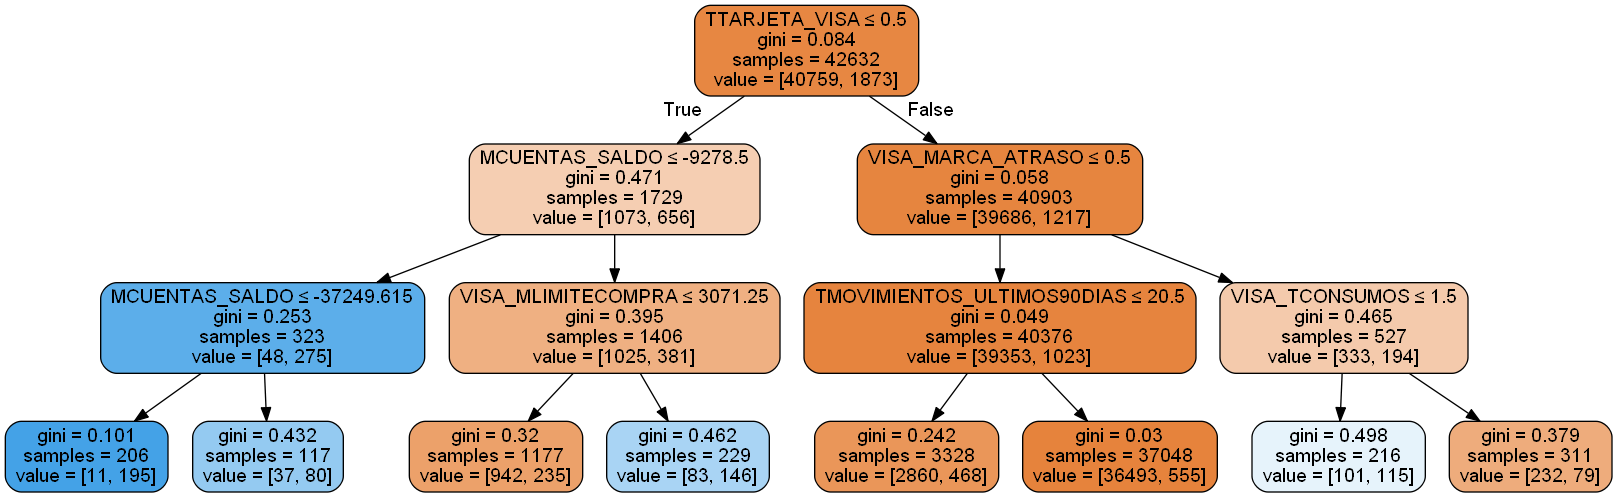

In [22]:
# Visualizamos el árbol de decisión usando graphviz
dot_data = export_graphviz(treeclf, out_file=None,  
                feature_names=atributos,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### 3.b.i) Lectura del árbol de decisión generado:

#### - Tenemos 1873 casos de baja  y 40759 que no se dieron de baja
    Esto lo vemos en el primer nodo, llamado "NODO RAIZ"
    
#### - Cada nodo de "SPLIT" tiene dos posibles salidas "True" o "False".
    True siempre a la izquierda y False a la derecha.
    
#### - Cuanto más "AZUL" sea el nodo, mayor probabilidad de baja tiene. Un nodo en "NARANJA" indica lo contrario.
    Como ejemplo, el nodo hoja inferior izquierdo tiene 94,66% (195/206).
    
#### - Las posibles reglas a aplicar para recorrer el lado izquierdo del árbol, son:

    TTARJETA_VISA <= 0.5 
      -> MCUENTAS_SALDO <= -9278.5
        -> MCUENTAS_SALDO <= -37249.615
          -> 195 bajas, 11 no bajas, P(clase=baja) = 94,66%, P(clase=continua) = 5,34%
          
    TTARJETA_VISA <= 0.5 
      -> MCUENTAS_SALDO <= -9278.5
        -> MCUENTAS_SALDO > -37249.615
          -> 80 bajas, 37 no bajas, P(clase=baja) = 68,37%, P(clase=continua) = 31,63%
          
    TTARJETA_VISA <= 0.5 
      -> MCUENTAS_SALDO > -9278.5
        -> VISA_MLIMITE_COMPRA <= 3071.25
          -> 235 bajas, 942 no bajas, P(clase=baja) = 20%, P(clase=continua) = 80%
          
    TTARJETA_VISA <= 0.5 
      -> MCUENTAS_SALDO > -9278.5
        -> VISA_MLIMITE_COMPRA > 3071.25
          -> 146 bajas, 83 no bajas, P(clase=baja) = 63,75%, P(clase=continua) = 36,25%

    ... 
    
- Completar las reglas del árbol de decisión.

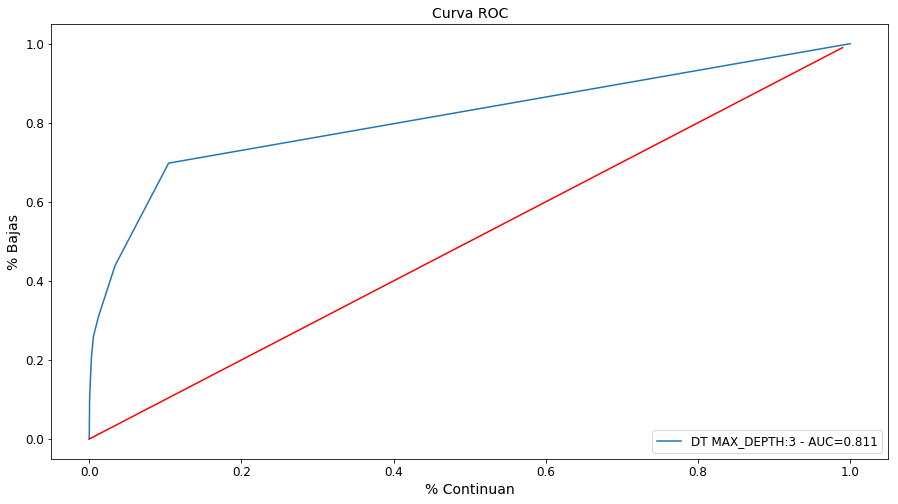

In [23]:
plt.figure(figsize=(15, 8))

y_pred_proba = treeclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Graficamos la curva roc del arbol
plt.plot(fpr,tpr,label="DT MAX_DEPTH:3 - AUC="+str(round(auc,3)))
plt.xlabel('% Continuan', fontsize=14)
plt.ylabel('% Bajas', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

### 3.b.ii) Curva ROC
La curva ROC nos permite visualizar como se distribuyen los casos positivos y negativos dentro de nuestro modelo. 

En resumen, nos indica que % de casos positivos (clase target) vamos a captar si tomamos X % de negativos, esto da una clara idea del poder predictivo del algoritmo. Este valor se resume en la métrica AUC (Area Under Curve), la cual indica qué tan "rápido" crece la curva (incluye mayor % de positivos) conforme avanza la cantidad de negativos.

Los **mejores algoritmos**, son aquellos que tienen curvas que **comienzan con pendientes muy grandes y crecen verticalmente muy rápido**, ya que esto indica que captan mayor cantidad de positivos para la misma cantidad de negativos.

Si lo analizamos en el contexto del Trabajo Práctico, cuanto más rápido crece verticalmente la curva, indica que **con la misma cantidad de contactos voy a obtener mejores ganancias**. Por ejemplo, si tenemos una curva ROC que para el 20% de los clientes que continuan (negativos) captamos el 60% de los clientes que se iban a dar de baja (positivos), podríamos decidir contactar al primer 20% de los clientes ordenados por la probabilidad de baja que defina el algoritmo y esto infiere una ganancia esperada de $**9.610.300**:

    -  20% * 58.196 (Cantidad que continuan) * -500 (costo del contacto al cliente)          =  -5.819.600
    -  60% * 2.707  (Cantidad de bajas)      * 9.500 (ganancia neta de retener al cliente)   =  15.429.900

    -  Neto: $9.610.300

Cuando se prueban distintos algoritmos, lo ideal es dibujar todas las curvas ROC en el mismo gráfico y comparar cómo se distancian unas de otras. En general, no existen grandes diferencias, pero son las pequeñas diferencias las que generan mayores ganancias.

Para comparar el poder predictivo de los algoritmos también se utiliza la métrica AUC (Área Bajo la Curva) pero esta métrica es genérica de la predicción completa y no aporta distintas visiones, depende del corte que querramos aplicar para nuestra campaña de retención (primer 10%, 20%, 40%, etc...)


### 3.b.iii) Importancia de las variables

- La primera columna es el nombre de la variable y la segunda indica la importancia relativa a la predicción. Los valores más altos indican que esa variable tiene mayor importancia para "dividir" las distintas clases de la variable objetivo (en nuestro caso los clientes que se dan de baja de los que continúan).

- Hay que tener claro que esto no implica una relación positiva, la importancia mide tanto relaciones positivas (menor cantidad de cuentas VISA más probabilidad de darse de baja) como las relaciones negativas (inversa).


In [24]:
# Calculamos la importancia de los atributos
pd.DataFrame({'Atributo':atributos,
              'importancia':treeclf.feature_importances_}).sort_values('importancia',
                                                                       ascending=False).head(10)

,Atributo,importancia
7,TTARJETA_VISA,0.448284
5,MCUENTAS_SALDO,0.206972
24,VISA_MARCA_ATRASO,0.135106
16,TMOVIMIENTOS_ULTIMOS90DIAS,0.106553
26,VISA_MLIMITECOMPRA,0.081249
29,VISA_TCONSUMOS,0.021835
37,C_MASTER_SALDO_LIM,0.000000
30,VISA_TADELANTOSEFECTIVO,0.000000
31,C_VISA_SALDO_LIM,0.000000
32,S_VISA_MASTER_SALDO,0.000000


### 3.b.iv) Matriz de Confusión del Modelo y Errores de Predicción
Analizando la matriz de confusión, podemos entender en qué casos el modelo acierta en la predicción y cuáles falla. En base a esto, podemos determinar las métricas de evaluación de modelos. Como ser:

- Exactitud (Accuracy) = Total de predicciones correctas / Total de predicciones
- Error de Predicción = 1 - Exactitud
- Sensitivity = Total de positivos acertados / Total de positivos reales

In [25]:
# Calculamos y vemos la matriz de confusión del modelo utilizando el conjunto de testing
y_pred = treeclf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
predicted_cols = ['pred_'+str(c) for c in le.classes_]
pd.DataFrame(conf, index = le.classes_, columns = predicted_cols)

,pred_0,pred_1
0,17340,97
1,617,217


- Exactitud (Accuracy) = 17557 / 18271 = 96.1%
- Error de Predicción = 1 - Exactitud = 3.9%
- Sensitivity = 217 / 834 = 26%

## 4. Función de Ganancia y Probabilidad de Corte

Vamos a definir una función de ganancia con la probabilidad de corte para el trabajo práctico.

Cada llamada que el banco realiza a los clientes le cuesta **500 pesos**. Si el modelo acierta en la predicción de retención del cliente el banco gana **10000 pesos**, es decir **9500 pesos** netos. En cambio si no acierta, el banco pierde **500 pesos**. En base a estos datos, el modelo debe definir a qué clientes hay que contactar maximizando las ganancias obtenidas por la campaña de retención. En el documento **Notas_Trabajo_Practico.doc** se indica cómo obtener la probabilidad necesaria del modelo para las bajas de manera de maximizar la ganancia en la campaña.

Este es un caso de uso de custom functions para scoring en Grid Searching, ya que por defecto la métrica usada para este tipo de algoritmos es AUC (Area Under the Curve) pero que en la vida real tiene poca aplicación.

In [26]:
prob_corte = float(0.05) # probabilidad de corte calculada 

#Definimos la función de ganancia a utilizar para el scoring en la busqueda:
def funcion_ganancia(clf, X, y_true):
    y_prob_baja = clf.predict_proba(X)[:, 1]
    
    ganancia = sum([(9500 if y_true[i] > 0 else -500) 
                    if y_prob_baja[i]  > prob_corte
                    else 0 
                    for i in range(len(y_prob_baja))])
    
    return ganancia

## 5. Construcción del modelo usando GridSearchCV con optimización de hiperparámetros

Las clase **GridSearchCV** se utiliza para automatizar la selección de los parámetros de un modelo, aplicando para ello la técnica de validación cruzada. Partiendo de un modelo y un conjunto de parámetros, GridSearchCV prueba múltiples combinaciones y selecciona los valores de los parámetros que ofrecen mayor rendimiento para un modelo y conjunto de datos. 

Los parámetros a optimizar son:

Medida            | Que hace
------------------|-------------
max_depth         | limita la altura del árbol (niveles-2)
max_features      | limita la cantidad de atributos a utilizar en una división
max_leaf_nodes    | limita la cantidad máxima de nodos hoja puede tener el árbol
min_samples_leaf  | cantidad mínima de muestras de una hoja
min_samples_split | cantidad mínima de muestras para dividir un nodo

Cada uno puede definir sus propios rangos de valores para cada parámetro, considerando que cuantos más parámetros se usen, el tiempo de procesamiento crece exponencialmente.

### 5.a) Definición de parámetros

In [50]:
# Definimos los parametros a evaluar:

PARAMETROS = {'max_depth':[6, 10, 12, 14, 16], 
              'max_features':[10, 20, 30, 50], 
              'max_leaf_nodes':[50, 100, 250, 500], 
              'min_samples_leaf':[70, 125, 1000, 2000],
              'min_samples_split':[100, 250, 300, 500]}

k_n_jobs = 4 # numero de iteraciones definidas

# Hacemos la búsqueda con GridSearchCV

model = DecisionTreeClassifier(random_state=1)  # modelo de árbol de decision
gs = GridSearchCV(model, 
                  PARAMETROS, 
                  n_jobs=k_n_jobs,
                  scoring=funcion_ganancia,
                  cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=1), #Cross Validation de 3 capas
                  verbose=1)
gs.fit(X, y)

# Mostramos los mejores resultados obtenidos

print(gs.best_estimator_)
print(gs.best_score_)

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   41.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  7.0min
[Parallel(n_jobs=4)]: Done 3840 out of 3840 | elapsed:  8.7min finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=20, max_leaf_nodes=50, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=125,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')
5484664.499285749


### 5.b) Interpretación de resultados
- Visualizaremos el árbol de decision generado con GridSearchCV  junto con las condiciones de split y los nodos resultantes.
- Analizaremos cómo contribuyeron las variables usadas en la predicción.
- Calcularemos el error de entrenamiento y de testeo del modelo generado.

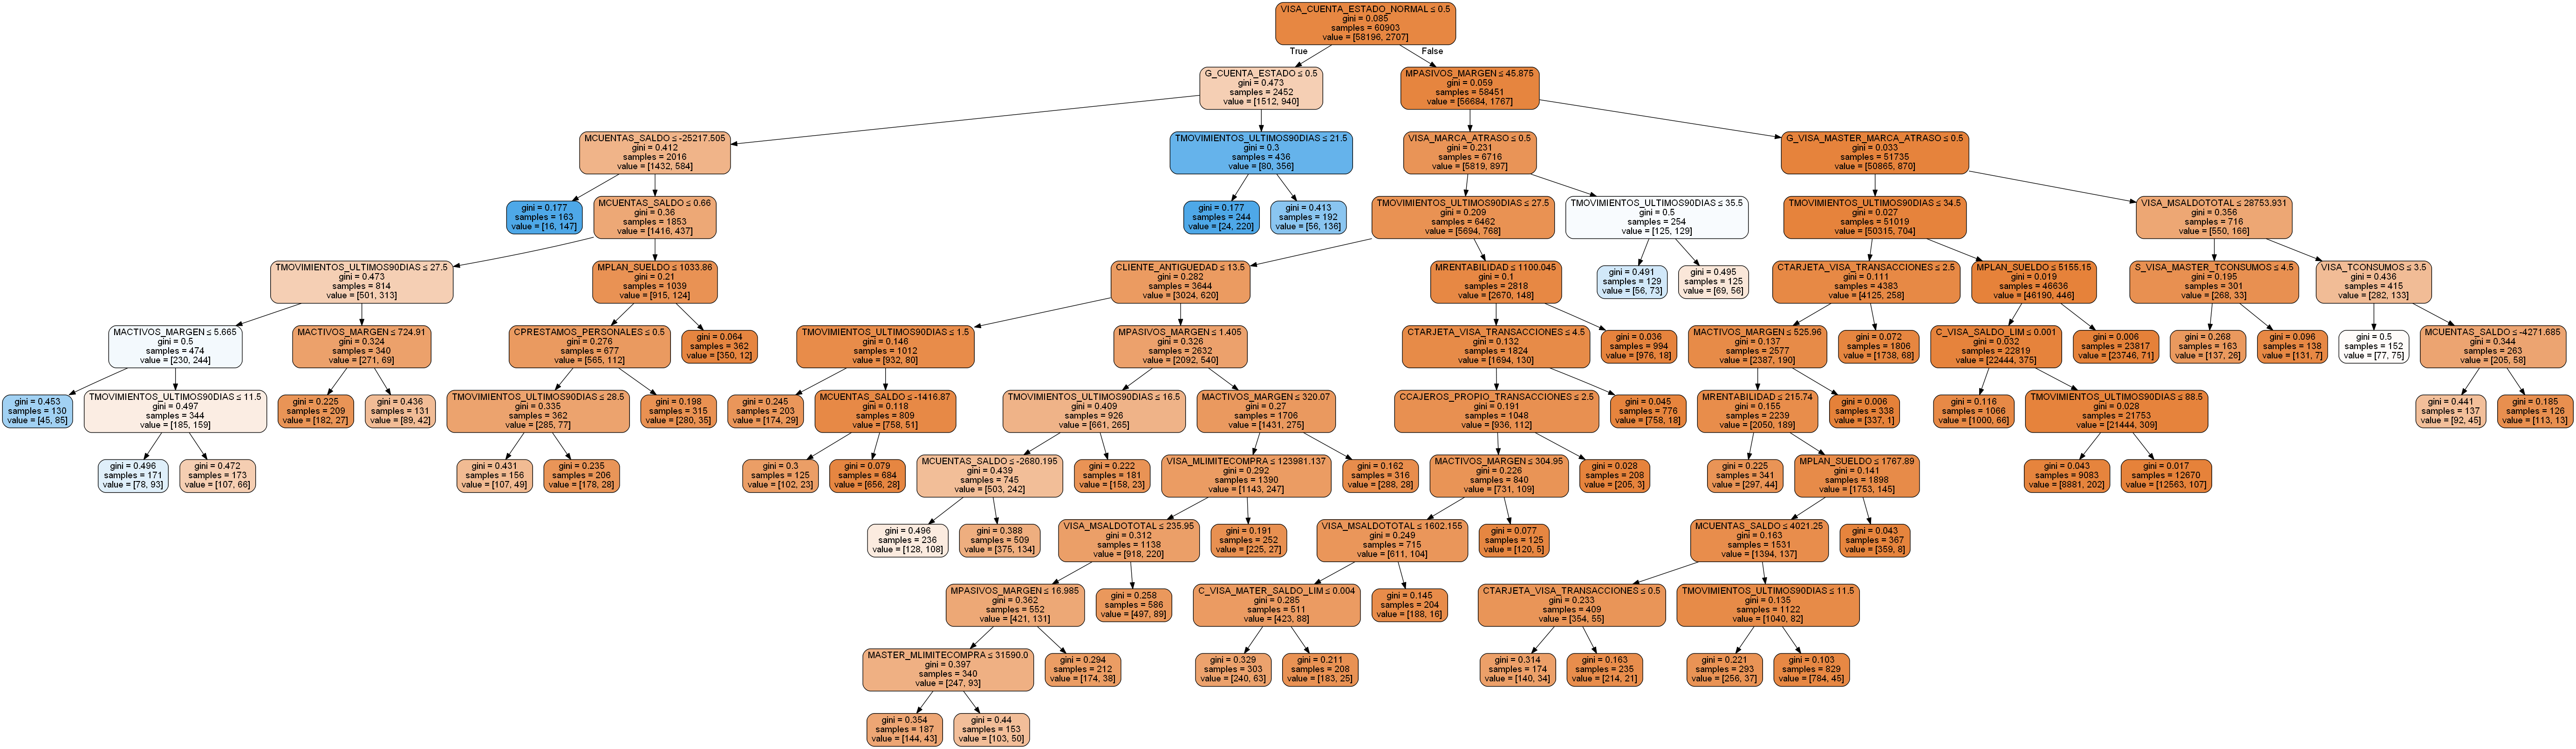

In [51]:
# Visualizamos el mejor árbol de decisión generado usando graphviz
dot_data=export_graphviz(gs.best_estimator_, 
                         out_file=None,
                         feature_names=X.columns,  
                         filled=True, rounded=True,
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())  

### 5.b.i) Importancia de las variables

In [52]:
# Calculamos la importancia de los atributos
pd.DataFrame({'Atributo':atributos,
              'importancia':gs.best_estimator_.feature_importances_}).sort_values('importancia',
                                                                       ascending=False).head(15)

,Atributo,importancia
48,VISA_CUENTA_ESTADO_NORMAL,0.365036
5,MCUENTAS_SALDO,0.138405
40,G_CUENTA_ESTADO,0.123763
4,MPASIVOS_MARGEN,0.113886
16,TMOVIMIENTOS_ULTIMOS90DIAS,0.086844
24,VISA_MARCA_ATRASO,0.046009
34,G_VISA_MASTER_MARCA_ATRASO,0.041758
1,CLIENTE_ANTIGUEDAD,0.014462
3,MACTIVOS_MARGEN,0.014418
25,VISA_MSALDOTOTAL,0.013824


### 5.b.ii) Curva ROC
Comparamos las curvas ROC y metricas AUC de los distintos árboles generados por GridSearching, para enteneder que valores de hiperparámetros mejoran la capacidad predictiva del algoritmo y que tan grande (o pequeña) es la diferencia entre los árboles.

In [53]:
# Como primer paso, vamos a probar todas las combinaciones de parametros
# y vamos a guardar los resultados de cada arbol en la lista "resultados"
resultados = []
# Recorremos las combinaciones de parametros y guardo el arbol entrenado, parametros y la prediccion
for p in gs.cv_results_['params']:
  treeclf2 = DecisionTreeClassifier(max_depth= p['max_depth'],
                                    max_features= p['max_features'],
                                    max_leaf_nodes= p['max_leaf_nodes'],
                                    min_samples_split= p['min_samples_split'],
                                    random_state=1)
  treeclf2.fit(X_train, y_train)
  y_pred_proba = treeclf2.predict_proba(X_test)[::,1]
  
  # Guardamos el arbol, la predicción y los parametros de cada ejecucion
  resultados.append({"arbol": copy.copy(treeclf2), "prediccion":copy.copy(y_pred_proba), "parametros":copy.copy(p)})

### Graficamos la curva ROC de cada árbol

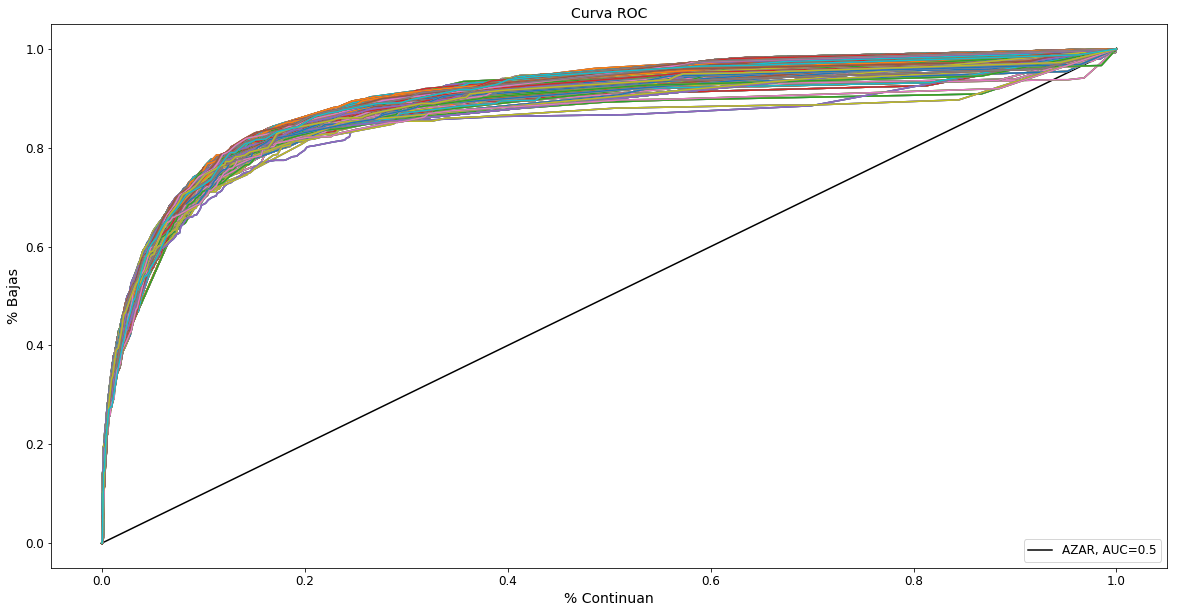

In [54]:
# Graficamos la curva ROC del arbol de cada iteracion
def graficarCurvaRoc(arbol):
  # Calculamos la probabilidad predecida
  y_pred_proba = r['prediccion']
  
  # Calculamos los valores de la curva ROC para graficar
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
  
  # Calculamos el Area Bajo la Curva (AUC) y la guardo
  auc = metrics.roc_auc_score(y_test, y_pred_proba)
  r['auc'] = auc

  # Graficamos
  plt.plot(fpr,tpr) #,label= "AUC="+str(auc))
  plt.legend(loc=4, fontsize=12)

# Inicializamos los labels del grafico
plt.figure(figsize=(20, 10))
plt.xlabel('% Continuan', fontsize=14)
plt.ylabel('% Bajas', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="black")

# Para cada arbol probado (en la variable resultados) graficamos la curva roc
for r in resultados:
    graficarCurvaRoc(r)

# Agregamos el titulo y configuro el tamaño de letra
plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

#### Preguntas importantes: ¿Cuál es el mejor modelo? ¿Qué % de corte eligirían para contactar a sus clientes?

### 5.b.iii) Análisis de hiperparámetros y sus rangos de valores

Ahora podemos listar, para cada valor de los parámetros como mejora (o empeora) el Area Bajo La Curva (AUC) del modelo generado.

***NO NECESARIAMENTE IMPLICA QUE EL MODELO ES MEJOR***.

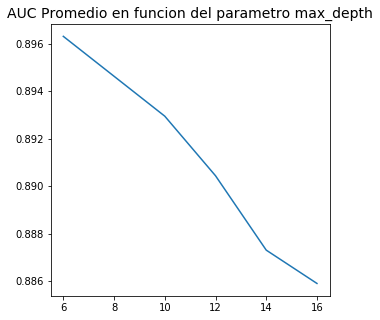

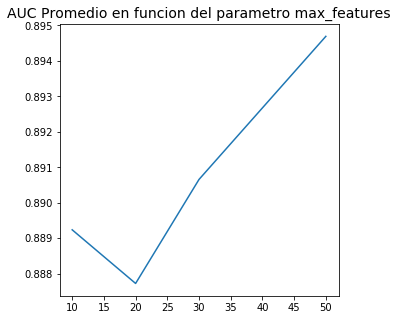

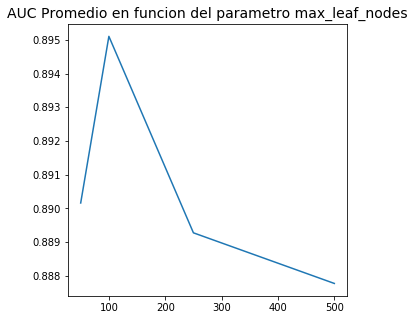

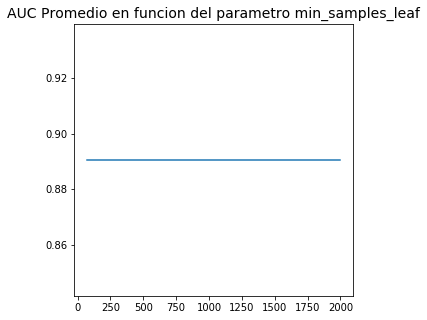

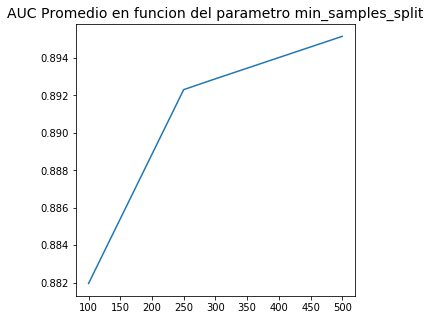

In [58]:
# Guardamos todas las combinatorias de parametros y auc probados
metricas = []
metricasxArbol = []
for r in resultados:
  metricasxArbol.append( { 'parametros':'{MD: '+str(r['parametros']['max_depth'])+', MF: '+str(r['parametros']['max_features'])+', ML: '+str(r['parametros']['max_leaf_nodes'])+', MS: '+str(r['parametros']['min_samples_split'])+'}', 'auc': r['auc']})
  for p in r['parametros']:
    metricas.append({'tipo':p, 'valor':r['parametros'][p], 'auc': r['auc']})

# Pasamos a dataframe pandas
metricas = pd.DataFrame(metricas)
metricasxArbol = pd.DataFrame(metricasxArbol)

# Calculamos las funciones agrupadas con tablas cruzadas
ct_av = pd.crosstab(metricas['valor'], metricas['tipo'], values=metricas['auc'], aggfunc=np.average)

# Graficamos los valores de cada parametros y la ganancia generada promedio
for c in ct_av.columns:
    plt.figure(figsize=(5, 5))
    plt.title('AUC Promedio en funcion del parametro '+str(c), fontsize=14)
    plt.plot(ct_av.dropna(subset=[c])[[c]])

In [59]:
# Por último, vemos que valores para cada parametro generan la mejor AUC.
metricasxArbol.sort_values('auc', ascending=False).head(20)

,auc,parametros
1241,0.903629,"{MD: 16, MF: 50, ML: 100, MS: 250}"
1233,0.903629,"{MD: 16, MF: 50, ML: 100, MS: 250}"
1237,0.903629,"{MD: 16, MF: 50, ML: 100, MS: 250}"
1245,0.903629,"{MD: 16, MF: 50, ML: 100, MS: 250}"
669,0.903354,"{MD: 12, MF: 30, ML: 100, MS: 250}"
665,0.903354,"{MD: 12, MF: 30, ML: 100, MS: 250}"
661,0.903354,"{MD: 12, MF: 30, ML: 100, MS: 250}"
657,0.903354,"{MD: 12, MF: 30, ML: 100, MS: 250}"
990,0.903079,"{MD: 14, MF: 50, ML: 100, MS: 300}"
986,0.903079,"{MD: 14, MF: 50, ML: 100, MS: 300}"


### 5.b.iv) Matriz de Confusión del Modelo y Errores de Predicción

In [60]:
# Calculamos y vemos la matriz de confusión del modelo utilizando el conjunto de testing
conf = confusion_matrix(y_test, gs.best_estimator_.predict(X_test))
predicted_cols = ['pred_'+str(c) for c in le.classes_]
pd.DataFrame(conf, index = le.classes_, columns = predicted_cols)

,pred_0,pred_1
0,17349,88
1,607,227


- Exactitud (Accuracy) = 17437 / 18271 = 95.43%
- Error de Predicción = 1 - Exactitud = 3.87%
- Sensitivity = 199 / 834 = 23.86%

## 6. Aplicando el modelo a datos nuevos

Ahora podemos aplicar el modelo generado a los datos nuevos donde no conocemos la clase (todos se indican como CONTINUA) para predecir las futuras bajas. El set de prueba con los nuevos datos a utilizar es **dataset_apply.csv** el cual contiene información sobre 61751 clientes (personas físicas) con paquetes "Premium".


In [34]:
#Leemos el dataset de aplicacion, para predecir futuras bajas:

dataset_aplicacion='dataset_apply.csv'
df_apply = pd.read_csv(dataset_aplicacion, sep=';', na_values='.', index_col=0)

# Siempre el primer paso es ejecutar la función de preparacion de datos que construimos
df_apply = preparacion_de_datos(df_apply)

# Borramos la CLASE y el campo FOTO_MES, ya que ambos son constantes, en este caso.
df_apply = df_apply.drop(['CLASE','FOTO_MES'], axis=1)

# Veamos como quedó el dataset
df_apply.head(10)


,CLIENTE_EDAD,CLIENTE_ANTIGUEDAD,MRENTABILIDAD,MACTIVOS_MARGEN,MPASIVOS_MARGEN,MCUENTAS_SALDO,MAUTOSERVICIO,TTARJETA_VISA,CTARJETA_VISA_TRANSACCIONES,CPRESTAMOS_PERSONALES,...,S_VISA_MASTER_SALDO,N_T_DEUDAS,G_VISA_MASTER_MARCA_ATRASO,S_VISA_MASTER_MLIMITECOMPRA,C_VISA_MATER_SALDO_LIM,C_MASTER_SALDO_LIM,S_VISA_MASTER_TCONSUMOS,S_VISA_MASTER_MCONSUMOTOTAL,G_CUENTA_ESTADO,G_CUENTA_ESTADO2
NUMERO_DE_CLIENTE,,,,,,,,,,,,,,,,,,,,,
14460750,58,204,1327.03,71.88,411.14,73.03,0.00,1,140,0,...,0.00,0,0,0.0,0.000000,0.240303,0.0,0.0,0,0
14460791,65,204,1147.71,4.33,806.17,50254.50,0.00,1,1,0,...,0.00,0,0,0.0,0.000000,0.000000,0.0,0.0,0,0
14460825,56,204,9611.30,5.79,8083.79,3104996.80,6124.86,1,2,0,...,0.00,0,0,0.0,0.000000,0.000000,0.0,0.0,0,0
14460901,55,204,2153.36,-179.44,1463.40,114724.75,18425.92,1,25,1,...,0.00,1,0,0.0,0.000000,0.019839,0.0,0.0,0,0
14460904,37,94,1692.54,-126.42,1450.34,195048.71,4591.26,1,6,0,...,0.00,0,0,0.0,0.000000,0.000000,0.0,0.0,0,0
14460942,50,204,996.31,-66.74,652.94,15470.44,28261.15,1,7,0,...,0.00,0,0,0.0,0.000000,0.000000,0.0,0.0,0,0
14460998,40,204,988.90,261.64,237.23,6728.01,286.12,1,2,0,...,0.00,0,0,0.0,0.000000,0.289286,0.0,0.0,0,0
14461243,66,204,284.89,-36.58,99.66,3453.71,0.00,1,4,2,...,411.54,1,0,49140.0,0.008375,0.000000,4.0,481.5,0,0
14461884,52,204,1214.38,-108.44,179.50,9659.77,0.00,1,12,0,...,0.00,0,0,0.0,0.000000,0.401569,0.0,0.0,0,0


In [80]:
# Encodeamos todos los atributos categóricos como booleanos con la función pd.get_dummies (sin incluir la variable objetivo). 
X_apply = pd.get_dummies(df_apply)
atributos = X_apply.columns

# Aplicamos la predicción al nuevo dataset
scores = gs.best_estimator_.predict_proba(X_apply)

# Agregamos al dataset la probabilidad de baja predicha con el modelo
df_result = copy.copy(df_apply)
df_result['PROB'] = scores[:,1]

# Veamos como quedó:
df_result.sort_values(by='PROB', ascending=False).head(20)

,CLIENTE_EDAD,CLIENTE_ANTIGUEDAD,MRENTABILIDAD,MACTIVOS_MARGEN,MPASIVOS_MARGEN,MCUENTAS_SALDO,MAUTOSERVICIO,TTARJETA_VISA,CTARJETA_VISA_TRANSACCIONES,CPRESTAMOS_PERSONALES,...,N_T_DEUDAS,G_VISA_MASTER_MARCA_ATRASO,S_VISA_MASTER_MLIMITECOMPRA,C_VISA_MATER_SALDO_LIM,C_MASTER_SALDO_LIM,S_VISA_MASTER_TCONSUMOS,S_VISA_MASTER_MCONSUMOTOTAL,G_CUENTA_ESTADO,G_CUENTA_ESTADO2,PROB
NUMERO_DE_CLIENTE,,,,,,,,,,,,,,,,,,,,,
13912844,55,14,15175.97,12949.06,0.00,-353005.41,0.00,0,0,1,...,1,0,0.00,0.000000,0.000000,0.0,0.00,0,0,0.90184
37220263,30,64,2158.53,1822.77,0.27,-28177.56,0.00,0,0,1,...,1,0,0.00,0.000000,0.000000,0.0,0.00,0,0,0.90184
19581939,49,123,1410.00,307.17,0.01,-28860.01,1574.44,0,0,0,...,0,0,0.00,0.000000,0.000000,0.0,0.00,0,0,0.90184
36663544,32,68,9151.69,1719.97,0.22,-59328.65,0.00,0,0,1,...,1,0,0.00,0.000000,0.000000,0.0,0.00,0,0,0.90184
27668109,56,36,3930.96,2834.68,0.00,-78578.87,0.00,0,0,1,...,1,0,0.00,0.000000,0.000000,0.0,0.00,0,0,0.90184
22192841,33,147,2888.08,2299.73,32.44,-31428.52,0.00,0,0,29,...,1,1,0.00,0.000000,0.365776,0.0,0.00,0,0,0.90184
50217672,34,8,9052.54,7737.22,0.00,-282571.63,0.00,0,0,0,...,0,0,0.00,0.000000,0.000000,0.0,0.00,0,0,0.90184
40806730,26,20,128903.34,24504.28,7.67,-939878.35,0.00,0,0,1,...,1,0,70200.00,1.089719,0.000000,3.0,1012.45,0,0,0.90184
21118133,36,14,12337.54,10523.37,-0.32,-363828.30,0.00,0,0,3,...,1,0,0.00,0.000000,0.000000,0.0,0.00,0,0,0.90184


## 7. Entregable Final
Para terminar, vamos a generar un archivo de salida "csv" con los clientes cuya probabilidad de baja sea mayor a la de corte que habíamos calculado.

In [0]:
# Clientes cuya probabilidad de baja sea mayor a la probabilidad de corte (0.05)

dataset_entrega='dataset_entrega.csv'

df_entregar = df_result[df_result.PROB > prob_corte]
df_entregar.to_csv(path_or_buf=dataset_entrega, sep=";", na_rep='.')
df_entregar.head(10)

## FIN